In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import allel

import sys
sys.path.append("../")
from pcshrink import Normalizer, ShrinkageCorrector

In [59]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

In [5]:
callset = allel.read_vcf("./data/data_fil.vcf.gz")

In [12]:
%%time
G = np.sum(callset["calldata/GT"], -1).astype(np.float32)
G[G==-2] = np.nan

CPU times: user 7.71 s, sys: 2.54 s, total: 10.3 s
Wall time: 10.3 s


In [14]:
norm = Normalizer(G, .02, "patterson")

In [17]:
Y = norm.Y

In [67]:
%%time
shrnk = ShrinkageCorrector(Y, 2)

CPU times: user 13.4 s, sys: 6.07 s, total: 19.5 s
Wall time: 841 ms


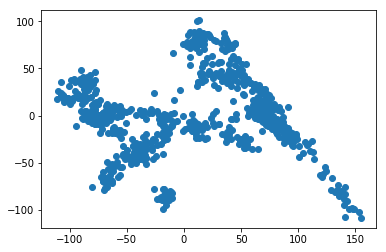

In [68]:
plt.scatter(shrnk.L[:, 0], -shrnk.L[:,1])